# SHAP Values

In [2]:
# !pip install shap

You should consider upgrading via the 'c:\users\vitor\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import shap

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [44]:
import seaborn as sns

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [5]:
# reading the data
df = pd.read_csv('Train.csv')

In [6]:
# imputing missing values in Item_Weight by median and Outlet_Size with mode
df['Item_Weight'].fillna(df['Item_Weight'].median(), inplace=True)
df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0], inplace=True)


In [7]:
df['Item_Identifier']

0       FDA15
1       DRC01
2       FDN15
3       FDX07
4       NCD19
        ...  
8518    FDF22
8519    FDS36
8520    NCJ29
8521    FDN46
8522    DRG01
Name: Item_Identifier, Length: 8523, dtype: object

In [8]:
df['Item_Type_Combined'] = df['Item_Identifier'].apply(lambda df: df[0:2])

In [9]:
df['Item_Type_Combined'].value_counts()

FD    6125
NC    1599
DR     799
Name: Item_Type_Combined, dtype: int64

In [10]:
df['Item_Type_Combined'] = df['Item_Type_Combined'].map({'FD':'Food',
                                                       'NC':'Non-Consumable',
                                                        'DR':'Drinks'})

In [11]:
df['Item_Type_Combined'].value_counts()

# operating years of the store
df['Outlet_Years'] = 2013 - df['Outlet_Establishment_Year']

# modifying categories of Item_Fat_Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [12]:
list(df)

['Item_Identifier',
 'Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Outlet_Sales',
 'Item_Type_Combined',
 'Outlet_Years']

In [13]:
# label encoding the ordinal variables
le = LabelEncoder()
df['Outlet'] = le.fit_transform(df['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()

In [14]:
for i in var_mod:
    df[i] = le.fit_transform(df[i])

In [15]:
df.shape

(8523, 15)

In [16]:
list(df)

['Item_Identifier',
 'Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Outlet_Sales',
 'Item_Type_Combined',
 'Outlet_Years',
 'Outlet']

In [17]:
fts = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_Combined','Outlet']

In [18]:
# one hot encoding the remaining categorical variables 
df = pd.get_dummies(df, columns=fts)

In [19]:
list(df)

['Item_Identifier',
 'Item_Weight',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales',
 'Outlet_Years',
 'Item_Fat_Content_0',
 'Item_Fat_Content_1',
 'Outlet_Location_Type_0',
 'Outlet_Location_Type_1',
 'Outlet_Location_Type_2',
 'Outlet_Size_0',
 'Outlet_Size_1',
 'Outlet_Size_2',
 'Outlet_Type_0',
 'Outlet_Type_1',
 'Outlet_Type_2',
 'Outlet_Type_3',
 'Item_Type_Combined_0',
 'Item_Type_Combined_1',
 'Item_Type_Combined_2',
 'Outlet_0',
 'Outlet_1',
 'Outlet_2',
 'Outlet_3',
 'Outlet_4',
 'Outlet_5',
 'Outlet_6',
 'Outlet_7',
 'Outlet_8',
 'Outlet_9']

In [20]:
# dropping the ID variables and variables that have been used to extract new variables
df.drop(['Item_Type','Outlet_Establishment_Year', 'Item_Identifier', 'Outlet_Identifier'],axis=1,inplace=True)

# separating the dependent and independent variables
X = df.drop('Item_Outlet_Sales',1)
y = df['Item_Outlet_Sales']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [21]:
# Need to load JS vis in the notebook
shap.initjs()

In [22]:
xgb_model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001, random_state=0)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.001, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
y_predict = xgb_model.predict(X_test)

In [24]:
mean_squared_error(y_test, y_predict)**(0.5)

1394.5361337744937

# Visualize SHAP

In [25]:
explainer = shap.TreeExplainer(xgb_model)

In [29]:
explainer

In [26]:
explainer.model

In [27]:
explainer.shap_values

<bound method Tree.shap_values of <shap.explainers._tree.Tree object at 0x00000239F351D460>>

In [28]:
explainer.expected_value

array([1377.20621306])

In [30]:
shap_values = explainer.shap_values(X_train)

In [33]:
X_train.shape

(6392, 29)

In [37]:
shapdf = pd.DataFrame(shap_values, columns = X_train.columns)

In [38]:
X_train

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_0,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
4776,16.350,0.029565,256.4646,4,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
7510,15.250,0.000000,179.7660,4,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5828,12.350,0.158716,157.2946,14,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5327,7.975,0.014628,82.3250,9,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4810,19.350,0.016645,120.9098,11,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,9.395,0.286345,139.1838,15,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5191,15.600,0.117575,75.6670,6,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
5390,17.600,0.018944,237.3590,11,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
860,20.350,0.054363,117.9466,6,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [39]:
shapdf

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_0,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,1.213779,-94.585686,952.973755,-384.051178,0.319032,0.0,0.670597,-0.673009,-4.302752,0.0,...,0.0,0.0,-0.368801,0.0,0.0,0.0,-0.784528,2.279993,1.463415,-0.189980
1,50.408489,120.428932,542.598328,-223.436676,1.436177,0.0,0.959451,-0.298713,-3.673303,0.0,...,0.0,0.0,-0.417403,0.0,0.0,0.0,0.115039,1.608211,5.420345,-0.221720
2,62.122940,-56.887211,241.488022,-74.126053,1.413394,0.0,-0.529457,-2.024851,9.487186,0.0,...,0.0,0.0,-0.143131,0.0,0.0,0.0,-0.454269,1.944276,1.305605,28.202440
3,6.263697,4.887280,-590.113220,-72.760147,-2.524984,0.0,1.169094,4.829130,1.282905,0.0,...,0.0,0.0,-0.104272,0.0,0.0,0.0,2.083250,2.192582,0.961580,-0.080195
4,26.661404,50.006992,-114.532082,-56.619503,-1.331520,0.0,0.133371,0.620000,0.869807,0.0,...,0.0,0.0,-3.080657,0.0,0.0,0.0,-0.873235,-43.175648,1.103109,-0.076828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,12.419301,-38.378300,-35.305759,-37.564022,-3.521800,0.0,0.091797,-0.329361,-2.210718,0.0,...,0.0,0.0,-0.114400,0.0,0.0,0.0,-0.215181,2.613256,0.618890,0.671013
6388,13.863039,-2.474838,-646.233032,-77.489357,-1.853014,0.0,0.710620,-0.236787,1.289462,0.0,...,0.0,0.0,3.376908,0.0,0.0,0.0,-0.502096,2.277738,0.951563,0.146630
6389,34.365772,108.942940,1132.046387,-74.406029,14.570121,0.0,0.483292,0.782855,1.240905,0.0,...,0.0,0.0,-0.557118,0.0,0.0,0.0,-0.947751,-16.375170,3.311064,-0.048429
6390,-30.270496,-22.673252,-313.511963,-74.547775,-1.162958,0.0,0.057200,-1.115711,1.681862,0.0,...,0.0,0.0,2.588353,0.0,0.0,0.0,-0.726513,6.262970,1.219304,-0.194457


In [41]:
shapdf.sum(axis = 1)

0        663.883301
1        698.552673
2        391.623688
3       -508.778992
4         26.858484
           ...     
6387   -1212.494385
6388    -574.549072
6389    1446.579468
6390    -302.572205
6391    -425.685333
Length: 6392, dtype: float32

In [70]:
shapdfcol = pd.DataFrame(shapdf.sum(axis = 0))

In [72]:
shapdfcol = shapdfcol.reset_index()

In [78]:
shapdfcol = shapdfcol.rename(columns = {'index':'features',0:'shap_values'})

In [80]:
shapdfcol.head()

,features,shap_values
0,Item_Weight,5394.427734
1,Item_Visibility,-7326.597168
2,Item_MRP,-9159.723633
3,Outlet_Years,109934.781250
4,Item_Fat_Content_0,20.733578


In [106]:
plt.rcParams["figure.figsize"] = (15,20)

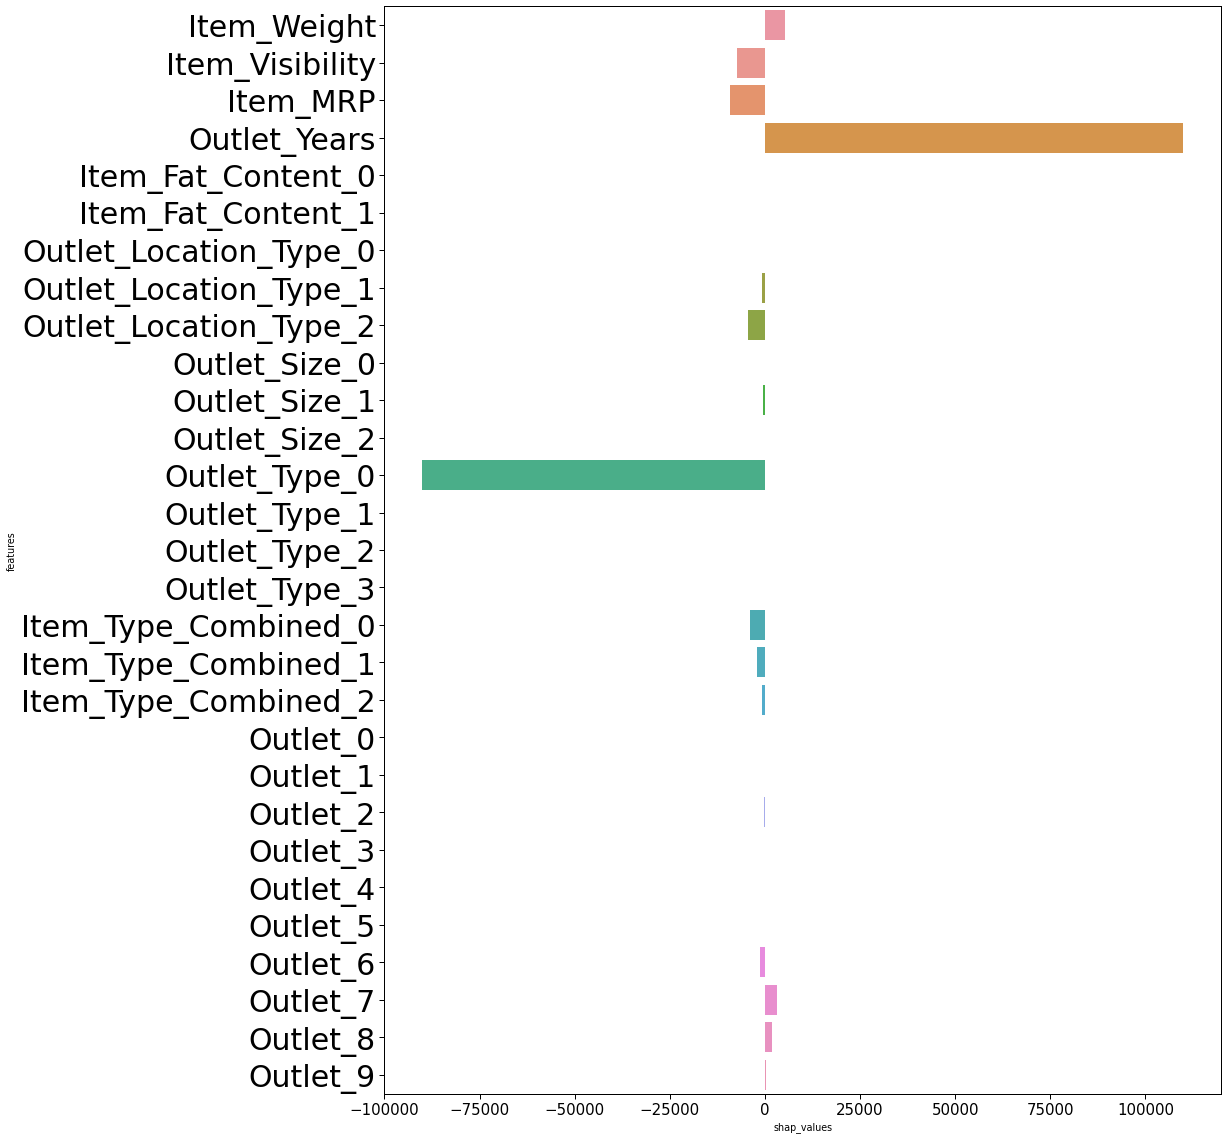

In [109]:
sns.barplot(y = 'features', x = 'shap_values', data = shapdfcol)
plt.yticks(size = 30)
plt.xticks(size = 15)
plt.show()

In [93]:
shap_values.shape

(6392, 29)

In [94]:
i = 4776

In [115]:
max(shapdf[shapdf.index == i])

'Outlet_Years'

In [117]:
min(shapdf[shapdf.index == i])

'Item_Fat_Content_0'

In [134]:
shapi = shapdf[shapdf.index == i].T

In [135]:
shapi = shapi.rename(columns = {i:'ishap'})

In [136]:
shapi['sinal'] = shapi['ishap'].apply(lambda x : 'neg' if x <= 0 else 'pos')

In [137]:
shapi['sinal'].value_counts()

neg    18
pos    11
Name: sinal, dtype: int64

In [152]:
shapi['pct'] = 100 * shapi['ishap'] / shapi.groupby('sinal')['ishap'].transform('sum')

In [164]:
shapi.sort_values(by='sinal')

,ishap,sinal,pct
Outlet_Type_2,0.000000,neg,-0.000000
Outlet_3,0.000000,neg,-0.000000
Outlet_Type_3,0.000000,neg,-0.000000
Outlet_4,0.000000,neg,-0.000000
Outlet_Type_1,0.000000,neg,-0.000000
Outlet_5,0.000000,neg,-0.000000
Outlet_Size_2,-0.962623,neg,0.109476
Outlet_Size_1,-0.424786,neg,0.048309
Outlet_1,0.000000,neg,-0.000000
Outlet_Size_0,0.000000,neg,-0.000000


In [163]:
shapi.groupby('sinal').agg({'pct':'sum'})

,pct
sinal,
neg,99.999992
pos,100.000008


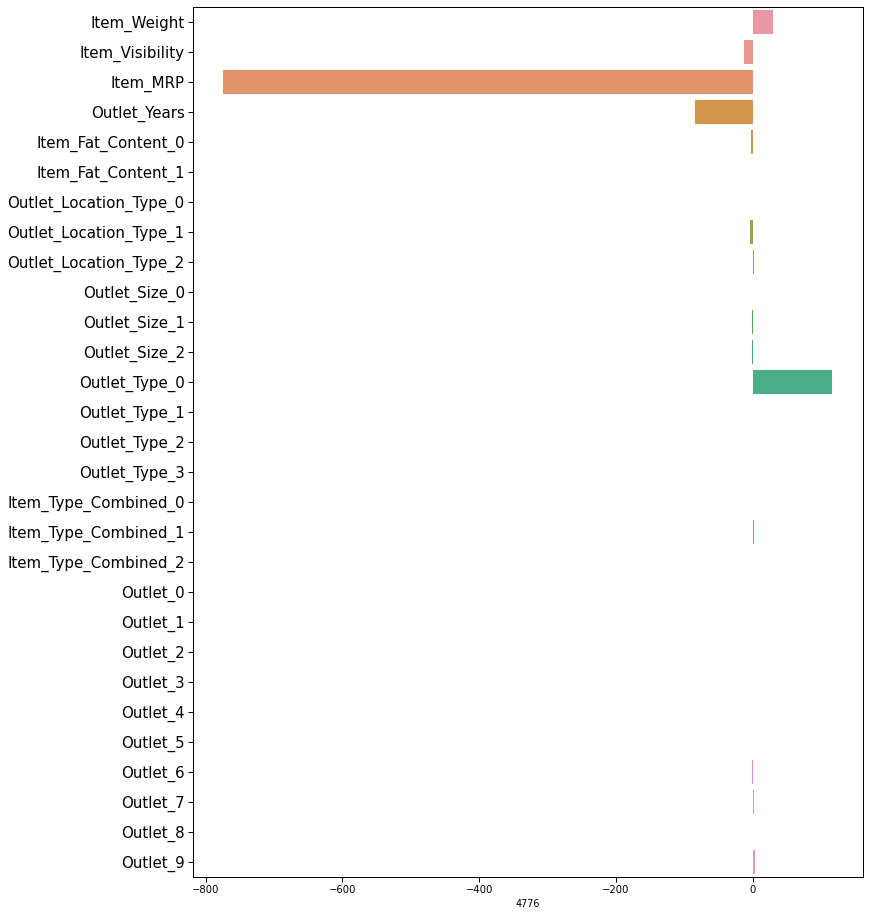

In [165]:
plt.rcParams["figure.figsize"] = (12,16)
sns.barplot(y = shapdf[shapdf.index == i].T.index, x = i, data = shapdf[shapdf.index == i].T)
plt.yticks(size = 15)
plt.xticks(size = 10)
plt.show()

In [95]:
shap.force_plot(explainer.expected_value, 
                shap_values[i], 
                features=X_train.loc[i],
               feature_names = X_train.columns)